In [1]:
import os
from collections import OrderedDict

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from PIL import Image
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [2]:
def iou_lossfun(predictions, targets, eps=1e-6):
    intersection = torch.sum(predictions * targets)
    union = torch.sum(predictions + targets) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou


class CrossEntropyIoULoss(nn.Module):
    def __init__(self):
        super(CrossEntropyIoULoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)

        return bce_loss + iou_lossfun(outputs, targets)

In [3]:
import random


class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = random.sample(os.listdir(image_dir), 1095)

        # Pre-load images and masks into memory
        self.image_data = []
        self.mask_data = []
        for image_name in self.images:
            image_path = os.path.join(self.image_dir, image_name)
            mask_path = os.path.join(self.mask_dir, image_name)

            new_shape = (128, 128)
            image = Image.open(image_path).convert("RGB")
            image.thumbnail(new_shape)
            mask = Image.open(mask_path).convert("L")
            mask.thumbnail(new_shape)

            self.image_data.append(image)
            self.mask_data.append(mask)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.image_data[idx]
        mask = self.mask_data[idx]

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [4]:
train_transform = transforms.Compose(
    [
        # transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))], p=0.3),
        # transforms.RandomHorizontalFlip(p=0.2),
        # transforms.RandomVerticalFlip(p=0.2),
        transforms.ToTensor(),
    ]
)

train_image_dir = "Conglomerate_Concrete_Crack_Detection/Train/images"
train_mask_dir = "Conglomerate_Concrete_Crack_Detection/Train/masks"
batch_size = 2
train_dataset = SegmentationDataset(
    train_image_dir, train_mask_dir, transform=train_transform
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_image_dir = "Conglomerate_Concrete_Crack_Detection/Test/images"
test_mask_dir = "Conglomerate_Concrete_Crack_Detection/Test/masks"

test_transforms = transforms.Compose([transforms.ToTensor()])

test_dataset = SegmentationDataset(
    test_image_dir, test_mask_dir, transform=test_transforms
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

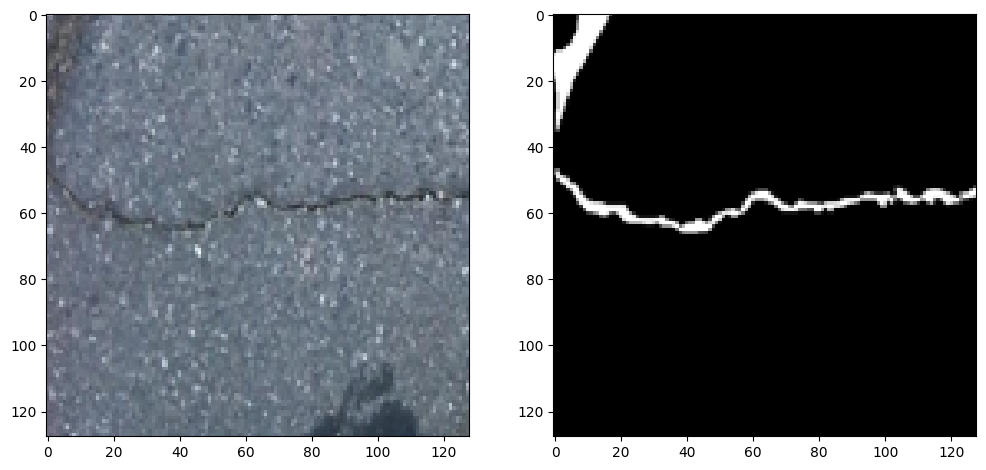

In [5]:
images, masks = next(iter(train_dataloader))

image = images[0].permute(1, 2, 0).cpu().numpy()
mask = masks[0].cpu().numpy().squeeze()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image)
axs[1].imshow(mask, cmap="gray")
plt.show()

In [7]:
lr = 0.0001
model = smp.Unet(
    encoder_name="timm-mobilenetv3_small_minimal_100",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = CrossEntropyIoULoss()


# Initialize variables for model checkpoint
best_test_loss = float("inf")
checkpoint_path = "best_model.pth"
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_iou, epoch_accuracy, epoch_loss = 0.0, 0.0, 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        out_binary = (torch.sigmoid(outputs) > 0.5).float()
        labels_binary = (labels > 0.5).float()
        iou = torchmetrics.classification.BinaryJaccardIndex()(
            out_binary, labels_binary
        )
        accuracy = torchmetrics.classification.BinaryAccuracy()(
            out_binary, labels_binary
        )
        epoch_accuracy += accuracy
        epoch_iou += iou

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_dataloader):.4f}, IoU: {epoch_iou / len(train_dataloader):.4f}, "
        f"Accuracy: {epoch_accuracy / len(train_dataloader):.4f}"
    )

    # Evaluate on the test set
    model.eval()  # Set model to evaluation mode
    test_iou, test_acc, test_loss = 0.0, 0.0, 0.0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            out_binary = (torch.sigmoid(outputs) > 0.5).float()
            labels_binary = (labels > 0.5).float()
            iou = torchmetrics.classification.BinaryJaccardIndex()(
                out_binary, labels_binary
            )
            accuracy = torchmetrics.classification.BinaryAccuracy()(
                out_binary, labels_binary
            )
            test_iou += iou
            test_acc += accuracy

    # Print test loss
    print(
        f"Test Loss after Epoch {epoch + 1}: {test_loss / len(test_dataloader):.4f},  IoU: {test_iou / len(train_dataloader):.4f}, "
        f"Acc: {(test_acc / len(train_dataloader)):.4f}"
    )

    # Save model checkpoint if test loss has improved
    if test_loss / len(test_dataloader) < best_test_loss:
        best_test_loss = test_loss / len(test_dataloader)
        # torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved new best model with test loss: {best_test_loss:.4f}")

Epoch [1/100], Loss: 0.6857, IoU: 0.0314, Accuracy: 0.5862
Test Loss after Epoch 1: 0.6373,  IoU: 0.0439, Acc: 0.6629
Saved new best model with test loss: 0.6373
Epoch [2/100], Loss: 0.5489, IoU: 0.0554, Accuracy: 0.6790
Test Loss after Epoch 2: 0.8456,  IoU: 0.0546, Acc: 0.6508
Epoch [3/100], Loss: 0.6914, IoU: 0.0398, Accuracy: 0.5909
Test Loss after Epoch 3: 0.6150,  IoU: 0.0391, Acc: 0.7305
Saved new best model with test loss: 0.6150
Epoch [4/100], Loss: 0.5876, IoU: 0.0502, Accuracy: 0.7610
Test Loss after Epoch 4: 0.1278,  IoU: 0.0521, Acc: 0.7259
Saved new best model with test loss: 0.1278
Epoch [5/100], Loss: 0.5429, IoU: 0.0654, Accuracy: 0.7780
Test Loss after Epoch 5: 0.8406,  IoU: 0.0648, Acc: 0.7902
Epoch [6/100], Loss: 0.5094, IoU: 0.0778, Accuracy: 0.7998
Test Loss after Epoch 6: 0.9952,  IoU: 0.0668, Acc: 0.7831
Epoch [7/100], Loss: 0.4767, IoU: 0.0936, Accuracy: 0.8278
Test Loss after Epoch 7: 0.3896,  IoU: 0.0873, Acc: 0.8277
Epoch [8/100], Loss: 0.4510, IoU: 0.1134, 

KeyboardInterrupt: 

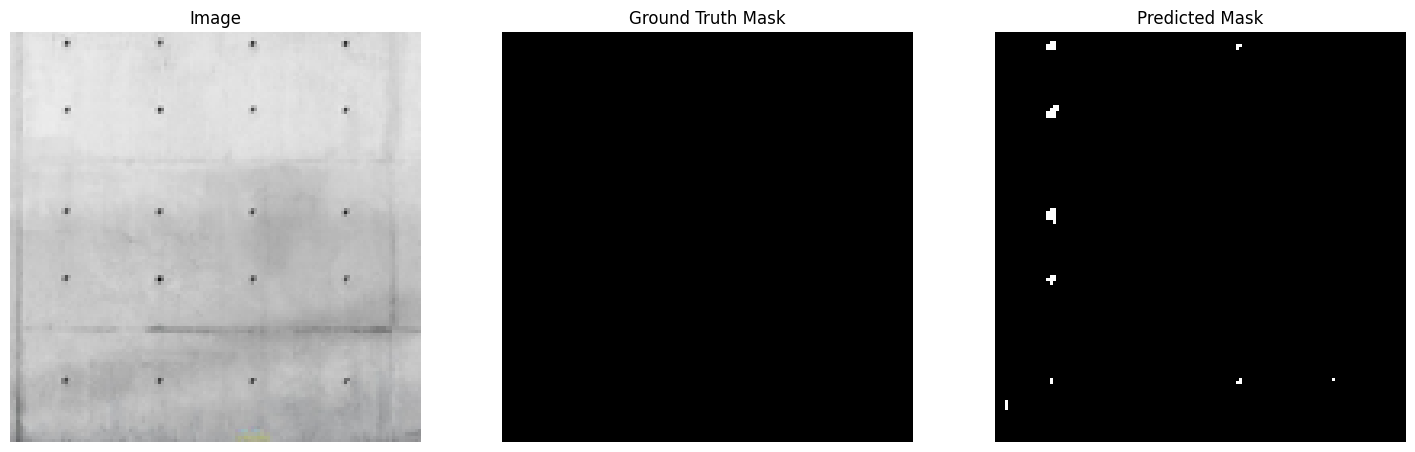

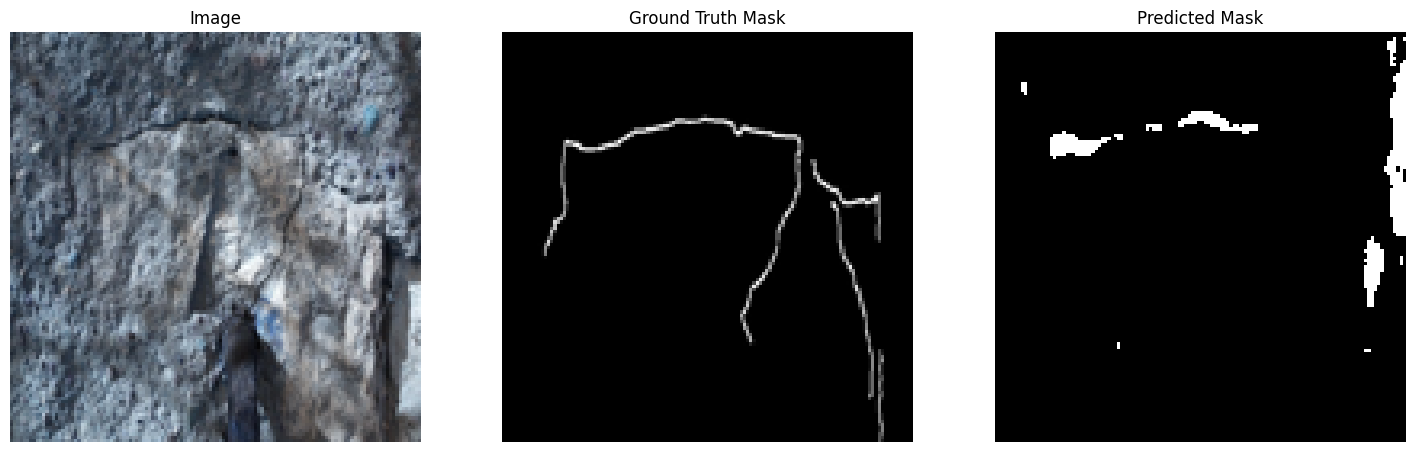

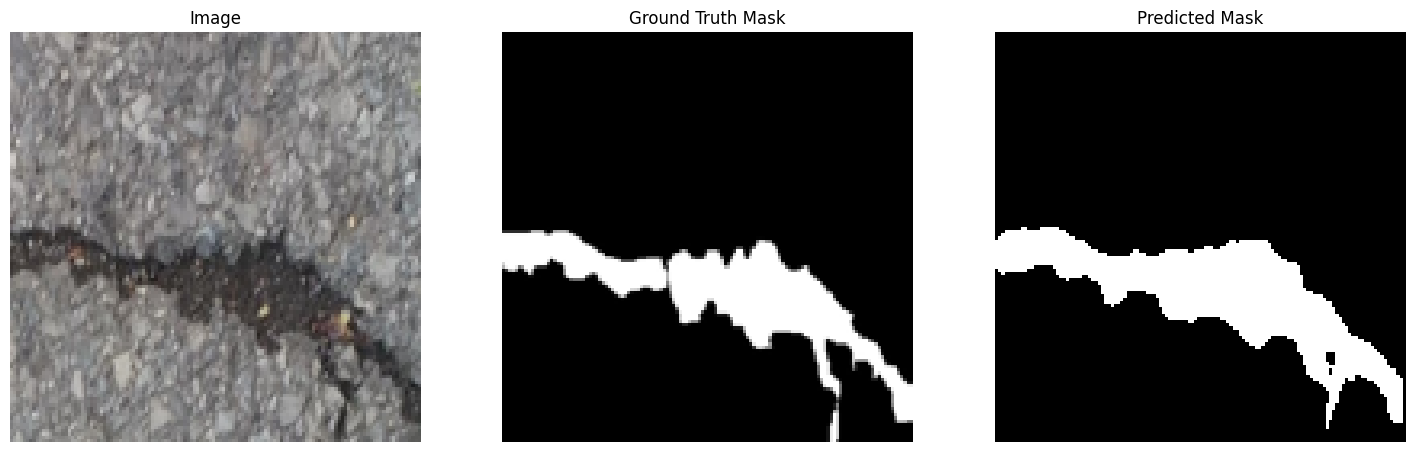

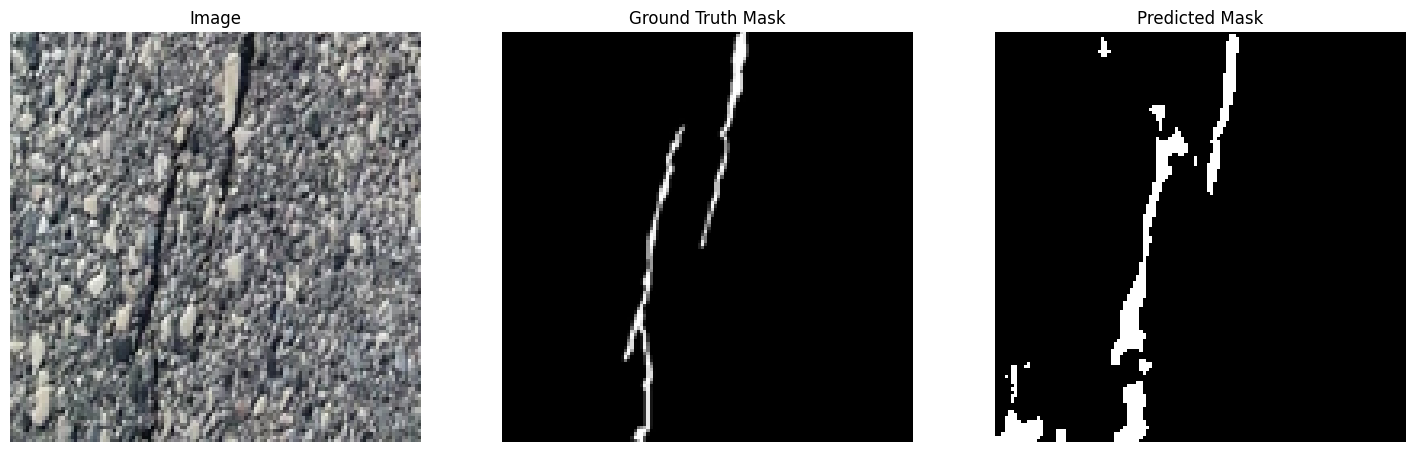

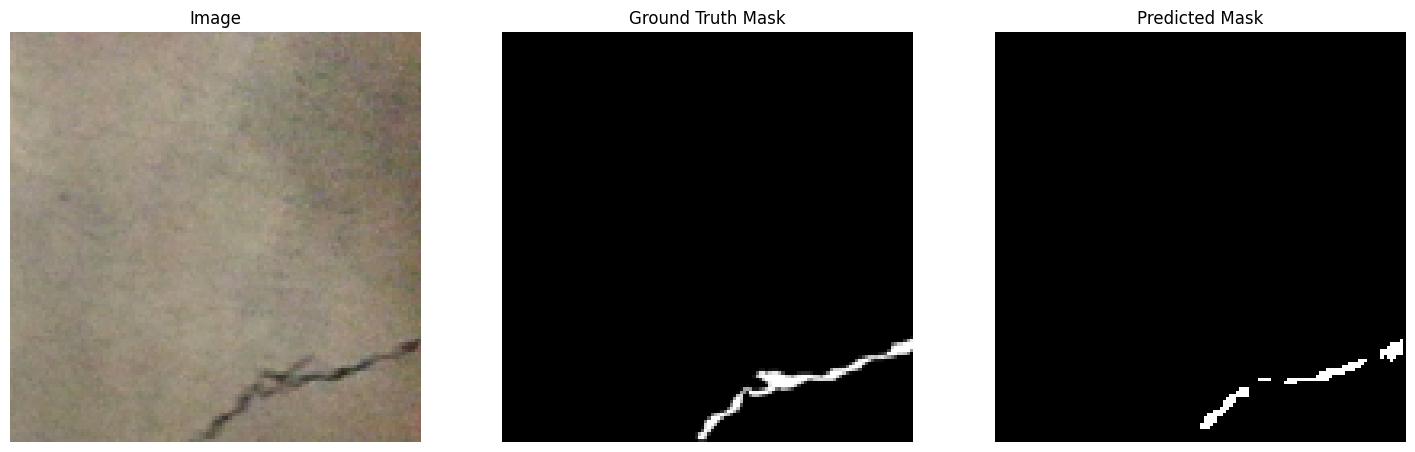

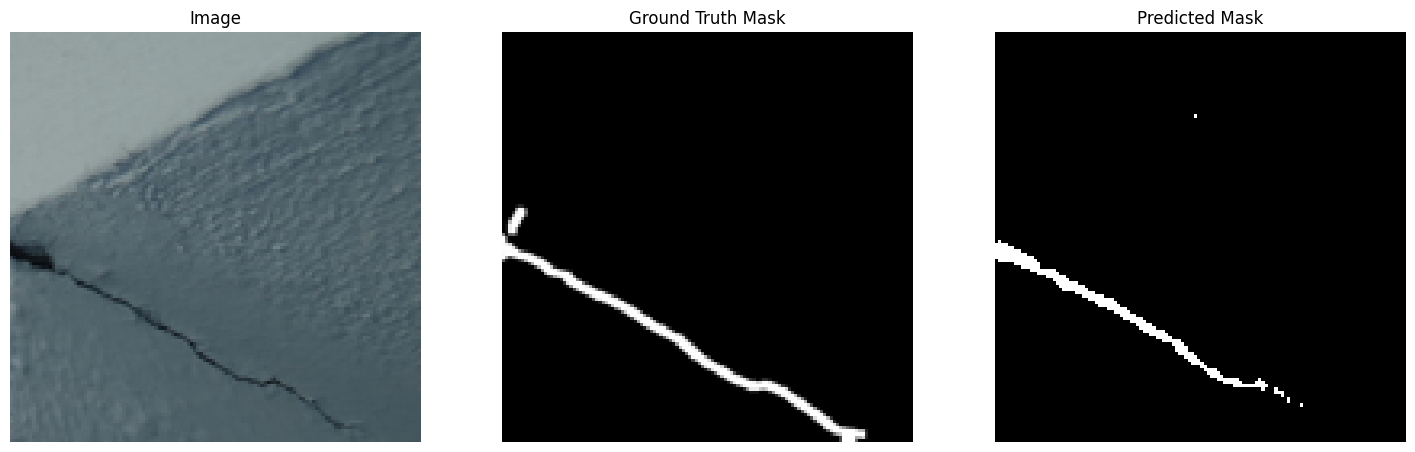

In [9]:
data_iter = iter(test_dataloader)
# data_iter = iter(train_dataloader)
for _ in range(6):
    images, masks = next(data_iter)
    outputs = model(images)

    image = images[0].permute(1, 2, 0).cpu().numpy()
    mask = masks[0].cpu().numpy().squeeze()

    predictions = torch.sigmoid(outputs[0])
    predicted_mask = (predictions > 0.5).cpu().numpy().squeeze()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(predicted_mask, cmap="gray")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

plt.show()

In [10]:
torch.save(model.state_dict(), checkpoint_path)

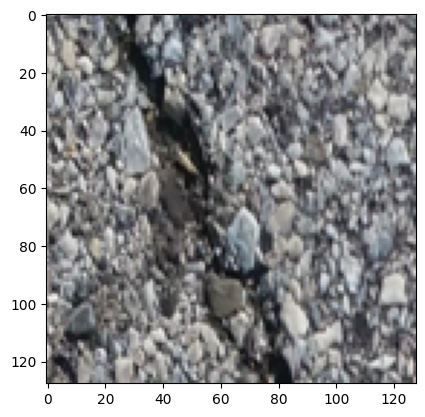

In [128]:
images, masks = next(iter(test_dataloader))
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())